In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
# 1. Load & Preprocess Data
data = pd.read_csv('wineData.csv')
data.dropna(inplace=True)

In [3]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,11.6,0.580,0.66,2.20,0.074,10.0,47.0,1.00080,3.25,0.57,9.0,3
1,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.4,3
2,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.7,3
3,10.4,0.440,0.42,1.50,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,3
4,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,3


In [4]:
# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,11.1,1.010,0.79,43.9,0.159,235.6,348.4,1.00204,3.08,1.71,12.3,3
1,11.8,0.830,1.32,43.1,0.176,149.0,246.9,1.01663,3.08,1.59,11.3,8
2,7.6,0.950,0.03,2.0,0.090,7.0,20.0,0.99590,3.20,0.56,9.6,5
3,11.3,1.080,1.32,53.3,0.138,145.2,285.4,1.01408,3.06,0.96,11.2,9
4,5.6,0.185,0.19,7.1,0.048,36.0,110.0,0.99438,3.26,0.41,9.5,6


In [6]:
# Replace numeric quality with labels
data = data.replace({'quality': {
    9: 'Good', 8: 'Good', 7: 'Good',
    6: 'Middle', 5: 'Middle',
    4: 'Bad', 3: 'Bad'
}})

In [7]:
# Map labels to integers
data['quality'] = data['quality'].map({'Good': 0, 'Middle': 1, 'Bad': 2})

In [8]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,11.1,1.010,0.79,43.9,0.159,235.6,348.4,1.00204,3.08,1.71,12.3,2
1,11.8,0.830,1.32,43.1,0.176,149.0,246.9,1.01663,3.08,1.59,11.3,0
2,7.6,0.950,0.03,2.0,0.090,7.0,20.0,0.99590,3.20,0.56,9.6,1
3,11.3,1.080,1.32,53.3,0.138,145.2,285.4,1.01408,3.06,0.96,11.2,0
4,5.6,0.185,0.19,7.1,0.048,36.0,110.0,0.99438,3.26,0.41,9.5,1


In [9]:
# Separate features and targets
X = data.drop(columns='quality').values
y = data['quality'].values

In [10]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # Use long for CrossEntropyLoss

In [12]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape)

torch.Size([16800, 11])


In [14]:
# 2. Create Neural Network Model Class
class MulticlassNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MulticlassNN, self).__init__()

        # Layer definitions
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.output = nn.Linear(hidden_sizes[3], output_size)

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))  # Hidden layer 1
        x = F.relu(self.fc2(x))  # Hidden layer 2
        x = F.relu(self.fc3(x))  # Hidden layer 3
        x = F.relu(self.fc4(x))  # Hidden layer 4
        x = self.output(x)       # Output layer (no softmax here)
        return x


In [15]:
# 3. Training Loop Function
def train_model(model, X_train, y_train, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == y_train).float().mean().item()

        loss_history.append(loss.item())
        accuracy_history.append(acc)

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Accuracy: {acc * 100:.2f}%")

    return loss_history, accuracy_history


In [16]:
# 4. Evaluate & Plot
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)
        acc = accuracy_score(y_test.numpy(), predictions.numpy())
        print(f"Test Accuracy: {acc * 100:.2f}%")

        # Confusion matrix
        cm = confusion_matrix(y_test.numpy(), predictions.numpy())
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


In [17]:
# 5. Plotting Function
def plot_metrics(losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title("Accuracy over Epochs")
    plt.show()


In [18]:
# Train
input_size = X_train.shape[1]
hidden_sizes = [64, 32, 16, 8]  # 4 hidden layers, easy to change later
output_size = 3  # 3 classes: Good, Middle, Bad

model = MulticlassNN(input_size, hidden_sizes, output_size)

epochs = 1000
learning_rate = 0.01

losses, accuracies = train_model(model, X_train, y_train, epochs, learning_rate)

Epoch 0 | Loss: 1.0871 | Accuracy: 43.02%
Epoch 100 | Loss: 0.7778 | Accuracy: 61.02%
Epoch 200 | Loss: 0.7480 | Accuracy: 61.77%
Epoch 300 | Loss: 0.7231 | Accuracy: 63.71%
Epoch 400 | Loss: 0.6968 | Accuracy: 65.95%
Epoch 500 | Loss: 0.6620 | Accuracy: 68.60%
Epoch 600 | Loss: 0.6430 | Accuracy: 69.75%
Epoch 700 | Loss: 0.6260 | Accuracy: 70.97%
Epoch 800 | Loss: 0.6255 | Accuracy: 71.50%
Epoch 900 | Loss: 0.6163 | Accuracy: 71.96%
Epoch 999 | Loss: 0.5974 | Accuracy: 72.51%


Test Accuracy: 63.52%


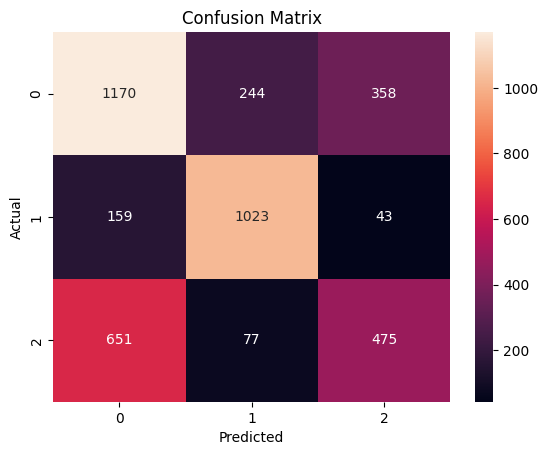

In [19]:
evaluate_model(model, X_test, y_test)

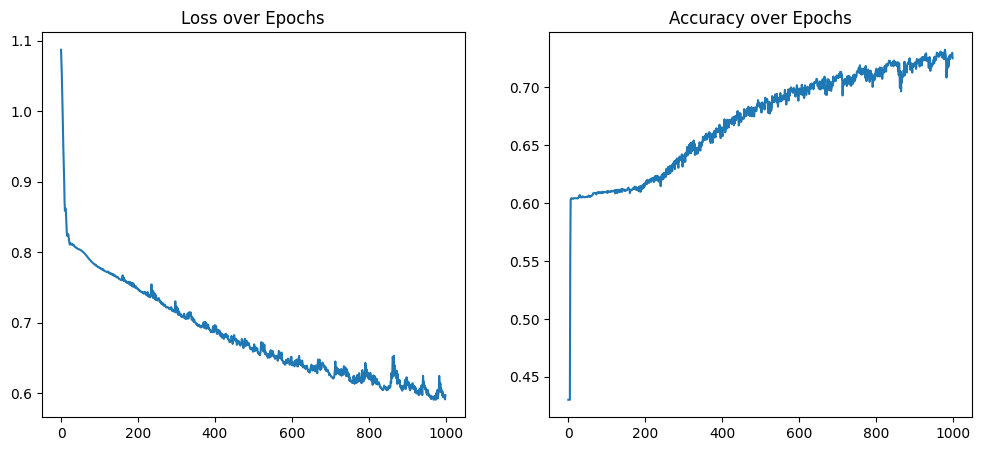

In [20]:
plot_metrics(losses, accuracies)